In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

pd.options.display.max_columns = None

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import   RandomForestClassifier
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import f1_score
from xgboost import XGBClassifier


In [2]:
df = pd.read_csv('conversion_data_train.csv')

In [3]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [4]:
print(df.describe(include='all'))
display(100*df.isnull().sum()/df.shape[0])


       country            age       new_user  source  total_pages_visited  \
count   284580  284580.000000  284580.000000  284580        284580.000000   
unique       4            NaN            NaN       3                  NaN   
top         US            NaN            NaN     Seo                  NaN   
freq    160124            NaN            NaN  139477                  NaN   
mean       NaN      30.564203       0.685452     NaN             4.873252   
std        NaN       8.266789       0.464336     NaN             3.341995   
min        NaN      17.000000       0.000000     NaN             1.000000   
25%        NaN      24.000000       0.000000     NaN             2.000000   
50%        NaN      30.000000       1.000000     NaN             4.000000   
75%        NaN      36.000000       1.000000     NaN             7.000000   
max        NaN     123.000000       1.000000     NaN            29.000000   

            converted  
count   284580.000000  
unique            NaN  
top

country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

In [5]:
df_sample = df.sample(10000)

In [6]:
corr = df_sample.corr().round(2)

C:\Users\jerem\AppData\Local\Temp\ipykernel_9536\2859636328.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_sample.corr().round(2)


<AxesSubplot: >

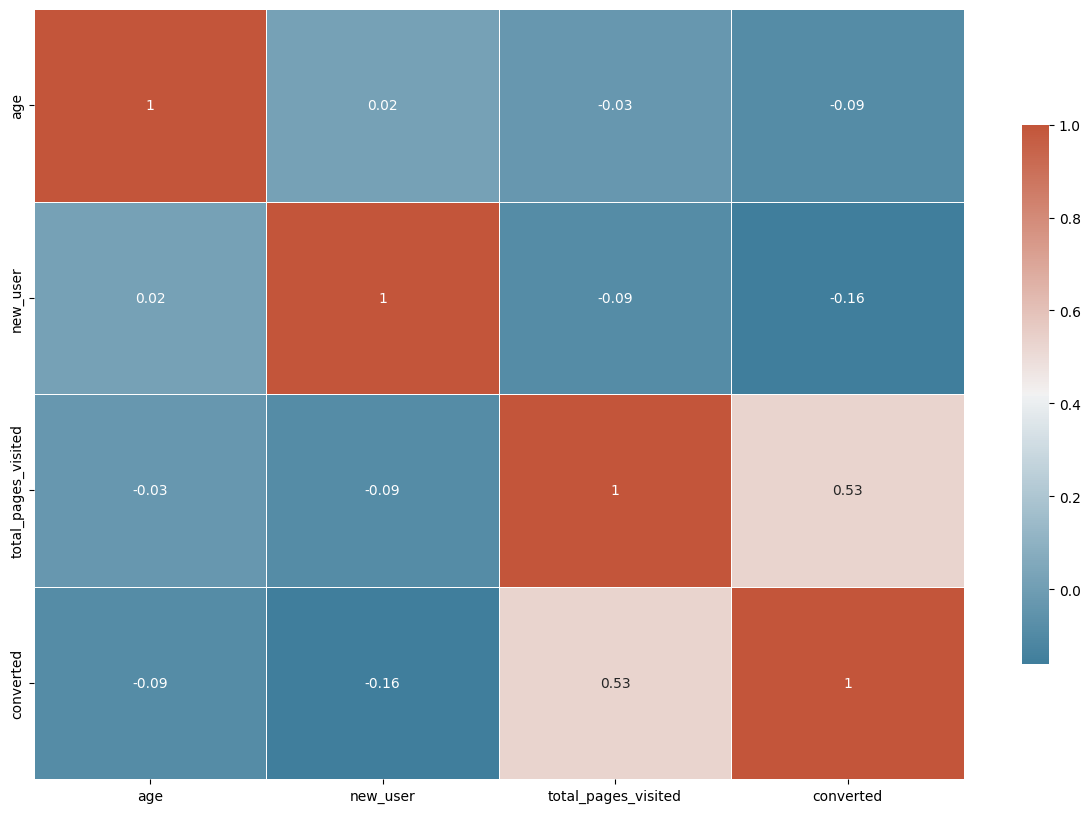

In [7]:
f, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, cmap=cmap, cbar_kws={"shrink": .7}, linewidths=.5)

In [8]:
df['converted'].value_counts(normalize=True)

0    0.967742
1    0.032258
Name: converted, dtype: float64

## test du model sur la variable avec la meilleur correlation

In [9]:
features_list = ['total_pages_visited']
target_variable = "converted"
X = df.loc[:,features_list]
Y = df.loc[:,target_variable]

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

In [11]:
featureencoder = StandardScaler()
X_train = featureencoder.fit_transform(X_train)

In [12]:
classifier = LogisticRegression() 
classifier.fit(X_train, Y_train)

LogisticRegression()

In [13]:
Y_train_pred = classifier.predict(X_train)

In [14]:
X_test = featureencoder.transform(X_test)
Y_test_pred = classifier.predict(X_test)

## performance

In [15]:
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.6938517686692869
f1-score on test set :  0.7060240963855423


## selection de model et hyperparametrage

In [16]:
target_name = "converted"
X = df.drop(target_name , axis=1)
Y = df.loc[:,target_variable]

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0, stratify=Y)

In [18]:
numeric_features = [1, 2, 4]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_features = [0, 3]
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first'))
    ])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [19]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [20]:
log_reg = LogisticRegression()
rand_forest_class = RandomForestClassifier()
xgb = XGBClassifier()
sgd = SGDClassifier()

In [21]:
log_reg.fit(X_train, Y_train)
Y_train_pred = log_reg.predict(X_train)
Y_test_pred = log_reg.predict(X_test)
print(f"F1 Score for the LogisticRegression model on train set: {f1_score(Y_train, Y_train_pred)}")
print(f"F1 Score for the LogisticRegression lodel on test set: {f1_score(Y_test, Y_test_pred)}\n")

rand_forest_class.fit(X_train, Y_train)
Y_train_pred = rand_forest_class.predict(X_train)
Y_test_pred = rand_forest_class.predict(X_test)
print(f"F1 Score for the RandomForestClassifier model on train set: {f1_score(Y_train, Y_train_pred)}")
print(f"F1 Score for the RandomForestClassifier model on test set: {f1_score(Y_test, Y_test_pred)}\n")

xgb.fit(X_train, Y_train)
Y_train_pred = xgb.predict(X_train)
Y_test_pred = xgb.predict(X_test)
print(f"F1 Score for the xgb model on train set: {f1_score(Y_train, Y_train_pred)}")
print(f"F1 Score for the xgb model on test set: {f1_score(Y_test, Y_test_pred)}\n")

sgd.fit(X_train, Y_train)
Y_train_pred = sgd.predict(X_train)
Y_test_pred = sgd.predict(X_test)
print(f"F1 Score for the sgd model on train set: {f1_score(Y_train, Y_train_pred)}")
print(f"F1 Score for the sgd model on test set: {f1_score(Y_test, Y_test_pred)}\n")


F1 Score for the LogisticRegression model on train set: 0.7662243667068757
F1 Score for the LogisticRegression lodel on test set: 0.755190729116369

F1 Score for the RandomForestClassifier model on train set: 0.8088585489760279
F1 Score for the RandomForestClassifier model on test set: 0.732616487455197

F1 Score for the xgb model on train set: 0.7781870595771941
F1 Score for the xgb model on test set: 0.7486194477791117

F1 Score for the sgd model on train set: 0.7639977377393552
F1 Score for the sgd model on test set: 0.7523647829250546



## ajuston les hyperparametres

In [23]:
rand_forest_class = RandomForestClassifier(max_depth= 10, min_samples_split=10, n_estimators= 150,  min_samples_leaf=10)
rand_forest_class.fit(X_train, Y_train)
Y_train_pred = rand_forest_class.predict(X_train)
Y_test_pred = rand_forest_class.predict(X_test)
print(f"F1 Score for the Random Forest model on train set: {f1_score(Y_train, Y_train_pred)}")
print(f"F1 Score for the Random Forest model on test set: {f1_score(Y_test, Y_test_pred)}")

scores_df = pd.DataFrame(columns = ['model', 'f1_score', 'set'])
scores_df = scores_df.append({'model': 'Random_Forest', 'f1_score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'Random_Forest', 'f1_score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)
scores_df

F1 Score for the Random Forest model on train set: 0.7737261531031152
F1 Score for the Random Forest model on test set: 0.751205400192864


C:\Users\jerem\AppData\Local\Temp\ipykernel_9536\1344205254.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'Random_Forest', 'f1_score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
C:\Users\jerem\AppData\Local\Temp\ipykernel_9536\1344205254.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'Random_Forest', 'f1_score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)


,model,f1_score,set
0,Random_Forest,0.773726,train
1,Random_Forest,0.751205,test


In [24]:
log_reg = LogisticRegression(penalty='l2', C=1,  intercept_scaling=1, max_iter=1000)
log_reg.fit(X_train, Y_train)
Y_train_pred = log_reg.predict(X_train)
Y_test_pred = log_reg.predict(X_test)

print(f"F1 Score for the Logistic Regression model on train set: {f1_score(Y_train, Y_train_pred)}")
print(f"F1 Score for the Logistic Regression model on test set: {f1_score(Y_test, Y_test_pred)}")

scores_df = scores_df.append({'model': 'Logistic_Regression', 'f1_score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'Logistic_Regression', 'f1_score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)
scores_df

F1 Score for the Logistic Regression model on train set: 0.7662243667068757
F1 Score for the Logistic Regression model on test set: 0.755190729116369


C:\Users\jerem\AppData\Local\Temp\ipykernel_9536\2311666974.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'Logistic_Regression', 'f1_score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
C:\Users\jerem\AppData\Local\Temp\ipykernel_9536\2311666974.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'Logistic_Regression', 'f1_score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)


,model,f1_score,set
0,Random_Forest,0.773726,train
1,Random_Forest,0.751205,test
2,Logistic_Regression,0.766224,train
3,Logistic_Regression,0.755191,test


In [25]:
xgb = XGBClassifier(base_score=0.5,
 booster="gbtree",
 colsample_bylevel=1,
 colsample_bytree=1,
 gamma=0,
 learning_rate=1,
 max_delta_step=0,
 max_depth=1,
 min_child_weight=10,
 n_estimators=150,
 nthread=1,
 objective='binary:logistic',
 reg_alpha=0,
 reg_lambda=1,
 scale_pos_weight=1,
 seed=0,
 silent=True,
 subsample=0.5,
 verbosity=0)
xgb.fit(X_train, Y_train)
Y_train_pred = xgb.predict(X_train)
Y_test_pred = xgb.predict(X_test)

print(f"F1 Score for the XGBoost Classifier model on train set: {f1_score(Y_train, Y_train_pred)}")
print(f"F1 Score for the XGBoost Classifier model on test set: {f1_score(Y_test, Y_test_pred)}\n")

scores_df = scores_df.append({'model': 'XGBoost', 'f1_score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'XGBoost', 'f1_score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)
scores_df

F1 Score for the XGBoost Classifier model on train set: 0.7663776493256262
F1 Score for the XGBoost Classifier model on test set: 0.7557581573896353



C:\Users\jerem\AppData\Local\Temp\ipykernel_9536\118614678.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'XGBoost', 'f1_score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
C:\Users\jerem\AppData\Local\Temp\ipykernel_9536\118614678.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'XGBoost', 'f1_score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)


,model,f1_score,set
0,Random_Forest,0.773726,train
1,Random_Forest,0.751205,test
2,Logistic_Regression,0.766224,train
3,Logistic_Regression,0.755191,test
4,XGBoost,0.766378,train
5,XGBoost,0.755758,test


In [26]:
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False)
sgd.fit(X_train, Y_train)
Y_train_pred = sgd.predict(X_train)
Y_test_pred = sgd.predict(X_test)

print(f"F1 Score for the sgd model on train set: {f1_score(Y_train, Y_train_pred)}")
print(f"F1 Score for the sgd model on test set: {f1_score(Y_test, Y_test_pred)}")

scores_df = scores_df.append({'model': 'sgd', 'f1_score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'sgd', 'f1_score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)
scores_df

F1 Score for the sgd model on train set: 0.769386012574711
F1 Score for the sgd model on test set: 0.760642009769714


C:\Users\jerem\AppData\Local\Temp\ipykernel_9536\1094196522.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'sgd', 'f1_score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
C:\Users\jerem\AppData\Local\Temp\ipykernel_9536\1094196522.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'sgd', 'f1_score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)


,model,f1_score,set
0,Random_Forest,0.773726,train
1,Random_Forest,0.751205,test
2,Logistic_Regression,0.766224,train
3,Logistic_Regression,0.755191,test
4,XGBoost,0.766378,train
5,XGBoost,0.755758,test
6,sgd,0.769386,train
7,sgd,0.760642,test


In [27]:
px.bar(scores_df, x="model", y='f1_score', color='set', barmode='group', width=900)

In [28]:
X_full = np.append(X_train,X_test,axis=0)
Y_full = np.append(Y_train,Y_test)


In [29]:
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False)
sgd.fit(X_full, Y_full)


SGDClassifier()

In [30]:
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)


Prediction set (without labels) : (31620, 5)


In [31]:
columns = ["country", "age", "new_user", "source", "total_pages_visited"]
data_without_labels = data_without_labels.loc[:, columns]
data_without_labels = data_without_labels.values
X_without_labels = preprocessor.transform(data_without_labels)


c:\Users\jerem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

c:\Users\jerem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but OneHotEncoder was fitted with feature names



In [32]:
data = {
    'converted': xgb.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_jeremy.csv', index=False)
